In [1]:
%matplotlib nbagg
from ipywidgets import widgets
from matplotlib.ticker import ScalarFormatter, PercentFormatter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib as mpl
import atlas_mpl_style as atlas
import numpy as np
from numpy.ma import masked_array as mask
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
atlas.use_atlas_style()

In [3]:
h5 = pd.HDFStore('/home/stanislaus/QT/Rel21/WithCDI/processed.h5')

In [4]:
working_points = [60, 70, 77, 85] # [30, 50, 60, 70, 77, 85, 90]
wp_types = ["FlatEff", "FixedCut", "Hyb"]
wp_labels = [f"{wp}%" for wp in working_points]
wp_strs = [f"{wp}" for wp in working_points]
wp_err_labels = [f"{wp}_err" for wp in working_points]
light_rej_labels = [f"{wp}_lr" for wp in working_points]
light_rej_err_labels = [f"{wp}_lr_err" for wp in working_points]
light_rej_syst_err_labels = [f"{wp}_lr_prop_err" for wp in working_points]
purity_labels = [f"{wp}_p" for wp in working_points]
purity_err_labels = [f"{wp}_p_err" for wp in working_points]
purity_syst_err_labels = [f"{wp}_p_prop_err" for wp in working_points]

In [5]:
algos = ["MV2c10",] # "MV2c10mu", "MV2c10rnn", "MV2cl100"]
collections = ["AntiKt4EMPFlowJets", "AntiKt4EMTopoJets"]
colordict = {"AntiKt4EMPFlowJets": "C1", "AntiKt4EMTopoJets": "C0"}
colName = dict(zip(collections,['Particle Flow', 'Calorimeter']))
wpTypeNames = ["Flat Efficiency", "Fixed Cut (CDI)", "Hybrid (CDI)"]
data = {}
for algo in algos:
    data[algo] = {}
    for wp in wp_types:
        data[algo][wp] = {}
        for collection in collections:
            data[algo][wp][collection] = h5[f"/{algo}/{wp}_{collection}"].query("bin_center < 510")
            data[algo][wp][collection].set_index("bin_center", inplace=True)

def plotBand(data, y, yerr, col, alpha, ax):
    x = data.index.values
    mid = data[y].values
    err = data[yerr].values
    high = mid + err
    low = mid - err
    ax.fill_between(x, high, low, facecolor=col, alpha=alpha, interpolate=True)

def plotRatio(baseline, other, y, y_stat_err, y_syst_err, ax, twined=False):
    inset_formatter = ScalarFormatter()
    inset_formatter.set_scientific(False)
    inset_formatter.fix_minus(u'−')
    x = baseline.index.values
    ys = baseline[y].values
    stat_err = np.sqrt(baseline[y_stat_err].values**2 + other[y_stat_err].values**2) / ys
    syst_err = np.sqrt(baseline[y_syst_err].values**2 + other[y_syst_err].values**2) / ys
    difference = (other[y].values - ys) / ys
    if twined:
        sel = (x >= 45) & (x <= 195)
        bandMask = (x > 45) & (x < 195)
        green = "paper:red"
        blue = "paper:blue"
        ax2 = ax.twinx()
        ax2.yaxis.set_major_formatter(inset_formatter)
        ax.yaxis.set_major_formatter(inset_formatter)
        ax.tick_params('y', labelcolor=green, color='#000000', zorder=4.)
        ax2.tick_params('y', labelcolor=blue, pad=45, color='#000000', zorder=4.)
        ax.fill_between(x[sel], stat_err[sel], -stat_err[sel], facecolor='#AAAAAA', alpha=0.7, zorder=3.)
        ax.fill_between(x[sel], syst_err[sel], -syst_err[sel], facecolor='#AAAAAA', alpha=0.3, zorder=2.)
        ax.plot(x[sel], syst_err[sel], '--', lw=1, color='#AAAAAA', zorder=2.)
        ax.plot(x[sel], -syst_err[sel], '--', lw=1, color='#AAAAAA', zorder=2.)
        # not in range:
        ax2.fill_between(mask(x, mask=bandMask), stat_err, -stat_err, facecolor='#AAAAAA', alpha=0.7, zorder=3.)
        ax2.fill_between(mask(x, mask=bandMask), syst_err, -syst_err, facecolor='#AAAAAA', alpha=0.3, zorder=2.)
        ax2.plot(mask(x, mask=bandMask), syst_err, '--', lw=1, color='#AAAAAA', zorder=2.)
        ax2.plot(mask(x, mask=bandMask), -syst_err, '--', lw=1, color='#AAAAAA', zorder=2.)
        # plot
        ax2.plot([0,500], [0,0], '-', lw=2, color='#444444', zorder=4.)
        ax.plot(x[sel], difference[sel], '.', color=green, ms=10., zorder=5.)
        ylim = np.max(np.abs(difference[sel])) * 1.05
        ax.set_ylim(-ylim, ylim)
        # border
        ax.plot([45,45], [-ylim, ylim], ':', lw=1, color='#000000', zorder=1.)
        ax.plot([195,195], [-ylim, ylim], ':', lw=1, color='#000000', zorder=1.)
        ax2.axvspan(0, 45, alpha=0.2, color='on:blue', zorder=1.)
        ax2.axvspan(195, 500, alpha=0.2, color='on:blue', zorder=1.)
        ax2.plot(mask(x, mask=sel), difference, '.',  ms=10., color=blue, zorder=5.)
        ylim = np.max(np.abs(difference[~sel])) * 1.05
        ax2.set_ylim(-ylim, ylim)
        for lbl in ax2.get_yticklabels():
            lbl.set_horizontalalignment('right')
    else:
        blue = "paper:blue"
        ax.yaxis.set_major_formatter(inset_formatter)
        ax.fill_between(x, stat_err, -stat_err, facecolor='#AAAAAA', alpha=0.7)
        ax.fill_between(x, syst_err, -syst_err, facecolor='#AAAAAA', alpha=0.3)
        ax.plot(x, syst_err, '--', lw=1, color='#AAAAAA')
        ax.plot(x, -syst_err, '--', lw=1, color='#AAAAAA')
        ax.plot(x, difference, '.', ms=10., color=blue, zorder=5.)
        ax.plot([0,500], [0,0], '-', lw=2, color='#444444', zorder=4.)
        ylim = np.max(np.abs(difference)) * 1.05
        ax.set_ylim(-ylim, ylim)
    

/usr/lib/python3.6/site-packages/matplotlib/__init__.py:917: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


<IPython.core.display.Javascript object>


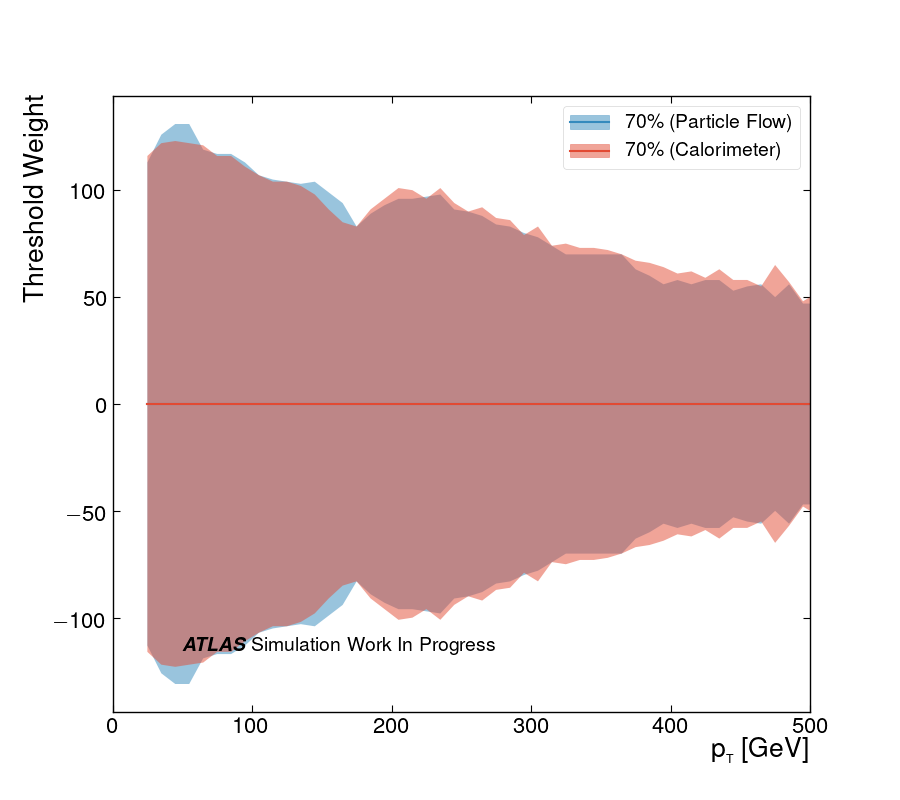

interactive(children=(Dropdown(description='Algorithm: ', options=('MV2c10',), value='MV2c10'), Checkbox(value=True, description='Particle Flow'), Checkbox(value=True, description='Calorimeter'), Dropdown(description='Working Point: ', index=3, options={'60%': 0, '70%': 1, '77%': 2, '85%': 3}, value=3), ToggleButtons(description='Plot Type: ', index=2, options=('Threshold Weight', 'Light Rejection', 'Purity'), value='Purity'), Dropdown(description='Working Point Type: ', options={'Flat Efficiency': 'FlatEff', 'Fixed Cut (CDI)': 'FixedCut', 'Hybrid (CDI)': 'Hyb'}, value='FlatEff'), Output()), _dom_classes=('widget-interact',))

In [9]:
fig = plt.figure(figsize=(9,8))
shown = False
@widgets.interact(algorithm=widgets.Dropdown(options=algos,
                                             description="Algorithm: ",
                                             value="MV2c10"),
                  wp_type=widgets.Dropdown(options=dict(zip(wpTypeNames, wp_types)),
                                            description="Working Point Type: ", value="FlatEff"),
                  wp=widgets.Dropdown(options=dict(zip(wp_labels, range(0,len(wp_labels)))),
                                             description="Working Point: ", value=3),
                  plotType=widgets.ToggleButtons(options=["Threshold Weight",'Light Rejection', 'Purity'],
                                                 description="Plot Type: ", value='Purity'),
                  pflow=widgets.Checkbox(description="Particle Flow", value=True),
                  topo=widgets.Checkbox(description="Calorimeter", value=True))
def intPlot(algorithm, pflow, topo, wp, plotType, wp_type):
    global shown
    fig.clear()
    
    if(pflow and topo and (plotType != 'Threshold Weight')):
        gridspec = gs.GridSpec(4, 1, hspace=0., wspace=0.)
        ax = fig.add_subplot(gridspec[0:3])
        ratio_ax = fig.add_subplot(gridspec[3], sharex=ax)
        ratio_ax.autoscale(axis='x', tight=True)
        two_plots = True
    else:
        ax = fig.gca()
        ax.autoscale(axis='x', tight=True)
        two_plots = False
    ax.text(0.1, 0.1, r'\textbf{\textit{ATLAS}} Simulation Work In Progress', transform=ax.transAxes, size=14)
    legend_items = []
    legend_labels = []
    cols = [col for col,inc in zip(collections,[pflow,topo]) if inc]
    if plotType == 'Light Rejection':
        for col in cols:
            plotBand(data[algorithm][wp_type][col], 
                     y=light_rej_labels[wp],
                     yerr=light_rej_syst_err_labels[wp],
                     col=colordict[col],
                     alpha=(0.5 if two_plots else 0.3),
                     ax=ax)
            plotBand(data[algorithm][wp_type][col], 
                     y=light_rej_labels[wp],
                     yerr=light_rej_err_labels[wp],
                     col=colordict[col],
                     alpha=(0.0 if two_plots else 0.6),
                     ax=ax)
            data[algorithm][wp_type][col].plot(y=light_rej_labels[wp], ax=ax, color=colordict[col])
            systBand = mpl.patches.Patch(color=colordict[col], alpha = (0.5 if two_plots else 0.3))
            statBand = mpl.patches.Patch(color=colordict[col], alpha = (0.0 if two_plots else 0.6))
            dataLine = mpl.lines.Line2D([], [], color=colordict[col])
            legend_items.append((systBand, statBand, dataLine))
            legend_labels.append(f'{wp_strs[wp]}\% ({colName[col]})')
        if two_plots:
            plotRatio(baseline = data[algorithm][wp_type]["AntiKt4EMTopoJets"],
                      other = data[algorithm][wp_type]["AntiKt4EMPFlowJets"],
                      y = light_rej_labels[wp],
                      y_stat_err = light_rej_err_labels[wp],
                      y_syst_err = light_rej_syst_err_labels[wp],
                      ax = ratio_ax,
                      twined=False)
    elif plotType == 'Purity':
        for col in cols:
            plotBand(data[algorithm][wp_type][col], 
                     y=purity_labels[wp],
                     yerr=purity_syst_err_labels[wp],
                     col=colordict[col],
                     alpha = (0.5 if two_plots else 0.3),
                     ax=ax)
            plotBand(data[algorithm][wp_type][col], 
                     y=purity_labels[wp],
                     yerr=purity_err_labels[wp],
                     col=colordict[col],
                     alpha=(0.0 if two_plots else 0.6),
                     ax=ax)
            data[algorithm][wp_type][col].plot(y=purity_labels[wp], ax=ax, color=colordict[col])
            systBand = mpl.patches.Patch(color=colordict[col], alpha = (0.5 if two_plots else 0.3))
            statBand = mpl.patches.Patch(color=colordict[col], alpha = (0.0 if two_plots else 0.6))
            dataLine = mpl.lines.Line2D([], [], color=colordict[col])
            legend_items.append((systBand, statBand, dataLine))
            legend_labels.append(f'{wp_strs[wp]}\% ({colName[col]})')
        if two_plots:
            plotRatio(baseline = data[algorithm][wp_type]["AntiKt4EMTopoJets"],
                      other = data[algorithm][wp_type]["AntiKt4EMPFlowJets"],
                      y = purity_labels[wp],
                      y_stat_err = purity_err_labels[wp],
                      y_syst_err = purity_syst_err_labels[wp],
                      ax = ratio_ax,
                      twined = True)
    elif plotType == 'Threshold Weight':
        for col in cols:
            plotBand(data[algorithm][wp_type][col], 
                     y=wp_labels[wp],
                     yerr=wp_err_labels[wp],
                     col=colordict[col],
                     alpha=0.5,
                     ax=ax)
            data[algorithm][wp_type][col].plot(y=wp_labels[wp], ax=ax, color=colordict[col])
            statBand = mpl.patches.Patch(color=colordict[col], alpha = 0.5)
            dataLine = mpl.lines.Line2D([], [], color=colordict[col])
            legend_items.append((statBand, dataLine))
            legend_labels.append(f'{wp_strs[wp]}\% ({colName[col]})')
                                 
    leg = ax.legend(legend_items, legend_labels, loc="upper right", prop={'size': 14})
    if two_plots:
        leg.set_title("Band Shows Stat. + Syst. Uncertainty", prop={'size': 10})
    ax.set_xlim(0, 500)
    #ax.set_xscale("log")
    if two_plots:
        atlas.set_xlabel(r'$\textsf{p}_{\textsf{\small T}}$ [GeV]', ax=ratio_ax)
        ratio_ax.set_ylabel(r'\normalsize $\frac{\textsf{Particle Flow} - \textsf{Calorimeter}}{\textsf{Calorimeter}}$')
        ratio_legend_items = [
            (mpl.patches.Patch(color="#AAAAAA", alpha=0.3), mpl.patches.Patch(edgecolor="#AAAAAA", linestyle='--', fill=False)),
            mpl.patches.Patch(color="#AAAAAA", alpha=0.7),
            mpl.lines.Line2D([], [], color="#444444", linewidth=2)
        ]
        ratio_ax.legend(ratio_legend_items,
                        ['Total Stat. + Syst. Uncertainty', 'Total Statistical Uncertainty', 'Baseline'],
                        loc=(0.6, 1.01),
                        prop={'size': 10})
    else:
        atlas.set_xlabel(r'$\textsf{p}_{\textsf{\small T}}$ [GeV]', ax=ax)
    atlas.set_ylabel(plotType, ax=ax)
    #ax.set_title(plotType)
    plt.show()


In [7]:
plot_dir = "/home/stanislaus/QT/Rel21/WithCDI/"
fig.savefig(f"{plot_dir}/85thresh.pdf")

In [8]:
h5.close()

In [13]:
data["MV2c10"]["FixedCut"]["AntiKt4EMPFlowJets"].head()

30%       50%       60%       70%  77%  85%  90%  30_err  \
bin_center                                                                  
25.0        0.939187  0.826829  0.629222  0.072275  0.0  0.0  0.0     0.0   
35.0        0.939187  0.826829  0.629222  0.072275  0.0  0.0  0.0     0.0   
45.0        0.939187  0.826829  0.629222  0.072275  0.0  0.0  0.0     0.0   
55.0        0.939187  0.826829  0.629222  0.072275  0.0  0.0  0.0     0.0   
65.0        0.939187  0.826829  0.629222  0.072275  0.0  0.0  0.0     0.0   

            50_err  60_err      ...             77_p_err       85_p_err  \
bin_center                      ...                                       
25.0        1666.0   353.0      ...        3.180443e-294  6.916413e-310   
35.0        1579.0   384.0      ...        6.916413e-310  2.245690e-307   
45.0        1706.0   407.0      ...        -3.990999e-01  -3.519030e-01   
55.0        1672.0   395.0      ...        6.916413e-310  2.245690e-307   
65.0        1412.0   348.0      ...        1.058585e-315  1.058586e-315   

                 90_p_err  30_p_prop_err  50_p_prop_err  60_p_prop_err  \
bin_center                                                               
25.0        8.348721e-320   0.000000e+00  6.916413e-310  1.530167e-317   
35.0       -2.353437e-185  6.916412e-310  2.154407e-314  1.581010e-319   
45.0        -1.607115e-01  -7.228665e-01  -3.813552e-01   3.976157e-01   
55.0       -2.353437e-185  6.916412e-310  2.154407e-314  1.581010e-319   
65.0        1.058586e-315  4.189677e-320  2.371515e-322  1.058420e-315   

            70_p_prop_err  77_p_prop_err  85_p_prop_err  90_p_prop_err  
bin_center                                                              
25.0         0.000000e+00  2.164436e-312 -2.353437e-185  6.916413e-310  
35.0       -2.353437e-185  4.940656e-324  2.121996e-313  4.940656e-324  
45.0         6.329406e-01  -6.425363e-02  -6.218293e-01  -5.648242e-01  
55.0       -2.353437e-185  1.482197e-323  2.121996e-313  4.940656e-324  
65.0         0.000000e+00  1.391308e-315  1.391309e-315  1.391349e-315  

[5 rows x 56 columns]